# Exercise 2: LQR & ILQR

In this exercise you will learn how to develop your own LQR and ILQR algorithms. For this task, we need to use CasADi: a library for symbolic calculation for python. This library composes functionalities not only symbolic calculation, but also automatic differentiation, numerical integration, linear and nonlinear programming solvers. We find various use cases for such tasks in control engineering, e.g., control for quadrotors and automotives. For further information and tutorials refer to the [CasADi documentation](https://web.casadi.org/).

Note: need install **matplotlib**

In [1]:
import time

import gymnasium
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
from ml_collections import config_dict
from numpy.typing import NDArray
from scipy.spatial.transform import Rotation as R

from crazyflow.constants import GRAVITY, MASS, J
from crazyflow.control import Control
from crazyflow.control.control import MAX_THRUST, MIN_THRUST
from crazyflow.sim.symbolic import symbolic


Set up the environment.

In [2]:
# set config for simulation
sim_config = config_dict.ConfigDict()
sim_config.control = Control.thrust
sim_config.thrust_freq = 500
sim_config.device = "cpu"
sim_config.n_drones = 1
sim_config.n_worlds = 1 #20

envs = gymnasium.make_vec(
    "DroneReachPos-v0",
    num_envs=sim_config.n_worlds,
    **sim_config,
)

print('observation space: \n', envs.observation_space)
print('action space: \n', envs.action_space)
print('time step:', 1 / envs.sim.freq)

observation space: 
 Dict('difference_to_goal': Box(-inf, inf, (1, 3), float32), 'pos': Box(-inf, inf, (1, 3), float32), 'quat': Box(-inf, inf, (1, 4), float32), 'rpy_rates': Box(-inf, inf, (1, 3), float32), 'vel': Box(-inf, inf, (1, 3), float32))
action space: 
 Box(0.028161688, 0.14834145, (1, 4), float32)
time step: 0.002


## 2.1 LQR

### 2.1.1 State Vector Representation

We need to reformat the dict obervation returned by the simulation into a numpy array required by our controller:
$$
\mathbf{x} =
\begin{bmatrix}
x & \dot{x} & y & \dot{y} & z & \dot{z} & \phi & \theta & \psi & \dot{\phi} & \dot{\theta} & \dot{\psi}
\end{bmatrix}^T
$$

   - $x$: Position in the x-direction.
   - $\dot{x}$: Velocity in the x-direction (x\_dot).
   - $y$: Position in the y-direction.
   - $\dot{y}$: Velocity in the y-direction (y\_dot).
   - $z$: Position in the z-direction.
   - $\dot{z}$: Velocity in the z-direction (z\_dot).
   - $\phi$: Roll angle.
   - $\theta$: Pitch angle.
   - $\psi$: Yaw angle.
   - $\dot{\phi}$: Roll angular velocity (phi\_dot).
   - $\dot{\theta}$: Pitch angular velocity (theta\_dot).
   - $\dot{\psi}$: Yaw angular velocity (psi\_dot).

In [3]:
def obs_to_state(obs: dict[str, NDArray]) -> NDArray:
    """Convert the observation from the obs dictionary to the state vector."""
    # Extract position
    pos = obs["pos"].squeeze()  # shape: (3,)
    
    # Extract linear velocity
    vel = obs["vel"].squeeze()  # shape: (3,)
    
    # Extract orientation as quaternion and convert to Euler angles
    quat = obs["quat"].squeeze()  # shape: (4,)
    euler = R.from_quat(quat).as_euler("xyz")  # shape: (3,), Euler angles
    # euler = euler[::-1] # [roll, pitch, yaw]
    # Extract angular velocity
    rpy_rates = obs["rpy_rates"].squeeze()  # shape: (3,)
    
    # Concatenate into a single state vector
    state = np.array([pos[0],vel[0],pos[1],vel[1],pos[2],vel[2],*euler, *rpy_rates])
    
    return state

### 2.1.2 Linearization of system dynamik

We’ve already created **symbolic representations** of the drone’s dynamics, **observation**, and **cost functions** using `CasADi`. For more details, please refer to `crazyflow/sim/symbolic.py`. The dynamics of the symbolic model is equivalent to the dynamics of the simulation.

Using the `symbolic_model.df_func` function to compute the linearized system matrices _A_ and _B_ at the equilibrium states $x_{op}$ and $u_{op}$. 

In [4]:
dt = 1 / envs.sim.freq
symbolic_model = symbolic(MASS, J, dt)

nx = 12 # dimension of state vector
nu = 4 # dimension of input vector

# Operating point
x_op = np.array([0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0])  # State equilibrium 
u_op = np.ones(4, dtype=np.float32) * 0.25 * MASS * GRAVITY  # Control equilibrium

df = symbolic_model.df_func(x_op, u_op)
A, B = df[0].toarray(), df[1].toarray()

print("A shape:", A.shape)  # Should be (12, 12)
print("B shape:", B.shape)  # Should be (12, 4)
# print("A :\n", A)
# print("B :\n", B)

A shape: (12, 12)
B shape: (12, 4)


**Note:** 

The ILQC controller requires **discretized, linearized system dynamics**:
($A_k$, $B_k$)

In contrast, the quadrotor model supplies **continuous, linearized system dynamics**:
($A_{\text{lin}}$, $B_{\text{lin}}$)

We need to define a function to discretize the linearized system.

In [5]:
def discretize_linear_system(A: NDArray, B: NDArray, dt: float, exact: bool = False) -> tuple[NDArray, NDArray]:
    """Discretization of a linear system.

    dx/dt = A x + B u --> xd[k+1] = Ad xd[k] + Bd ud[k] where xd[k] = x(k*dt)

    Args:
        A: System transition matrix.
        B: Input matrix.
        dt: Step time interval.
        exact: Flag to use exact discretization.

    Returns:
        The discrete linear state matrix Ad and the discrete linear input matrix Bd.
    """
    state_dim, input_dim = A.shape[1], B.shape[1]

    if exact:
        M = np.zeros((state_dim + input_dim, state_dim + input_dim))
        M[:state_dim, :state_dim] = A
        M[:state_dim, state_dim:] = B

        Md = scipy.linalg.expm(M * dt)
        Ad = Md[:state_dim, :state_dim]
        Bd = Md[:state_dim, state_dim:]
    else:
        Identity = np.eye(state_dim)
        Ad = Identity + A * dt
        Bd = B * dt

    return Ad, Bd

### 2.1.3 Quadratic cost function

In [6]:
q_diag = [
    5, 3,  # penalize position and velocity
    5, 3,
    5, 3,   
    0.1, 0.1, 2,  # penalize orientation  
    1, 1, 1  # penalize angular velocity
]
r_diag = [1, 1, 1, 1]
Q_lqr = np.diag(q_diag)  # State cost
R_lqr = np.diag(r_diag)  # Control cost

### 2.1.4 LQR controller gain

In [7]:
Ad, Bd = discretize_linear_system(A, B, dt)#, exact=True)

P = scipy.linalg.solve_discrete_are(Ad, Bd, Q_lqr, R_lqr)

btp = np.dot(Bd.T, P)

gain_lqr = np.dot(np.linalg.inv(R_lqr + np.dot(btp, Bd)),
                np.dot(btp, Ad))

# We can also comment out the above two lines of code 
# and use the following line instead to compute for the continuous-time case

# P = scipy.linalg.solve_continuous_are(A, B, Q_lqr, R_lqr)

# gain_lqr = np.dot(np.linalg.inv(R_lqr), np.dot(B.T, P))

# print("A (discretized):\n", Ad)
# print("B (discretized):\n", Bd)
print("gain:\n", gain_lqr)
print("shape of gain:", gain_lqr.shape)


gain:
 [[-0.198041   -0.22132086  0.198041    0.22132086  0.98249159  0.77068272
  -0.6281836  -0.6281836  -0.20760864 -0.09047658 -0.09047658 -0.14746368]
 [ 0.198041    0.22132086  0.198041    0.22132086  0.98249159  0.77068272
  -0.6281836   0.6281836   0.20760864 -0.09047658  0.09047658  0.14746368]
 [ 0.198041    0.22132086 -0.198041   -0.22132086  0.98249159  0.77068272
   0.6281836   0.6281836  -0.20760864  0.09047658  0.09047658 -0.14746368]
 [-0.198041   -0.22132086 -0.198041   -0.22132086  0.98249159  0.77068272
   0.6281836  -0.6281836   0.20760864  0.09047658 -0.09047658  0.14746368]]
shape of gain: (4, 12)


### 2.1.5 Regulate the drone to the target state

Note: you can use the `Tab`-key to switch between world and body camera in mujoco.

In [8]:
SEED = 42

obs, info = envs.reset()#seed=SEED)
state = obs_to_state(obs)
# print(obs)
# Step through the environment
x_log = [state[0]]
y_log = [state[2]]
z_log = [state[4]]
thrust_log = []
fps = 60

for i in range(2500):
    
    goal = np.array([0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0]) # set goal state

    control_input = -gain_lqr @ (state - goal) + u_op
    control_input = np.clip(control_input, MIN_THRUST, MAX_THRUST) 
    action = control_input.reshape(1,4).astype(np.float32)
    # print(action)
    thrust_log.append(action.flatten())
    obs, reward, terminated, truncated, info = envs.step(action)

    state = obs_to_state(obs)
    # print('state:',state)
    x_log.append(state[0])
    y_log.append(state[2])
    z_log.append(state[4])
    
    if terminated or truncated:
        print("Episode ended at step:", i)
        break
    
    if (i * fps) % envs.sim.freq < fps:
        envs.render()
        time.sleep(1 / fps)
    
envs.sim.close()
envs.close()

### 2.5.6 Plots

Plot of position

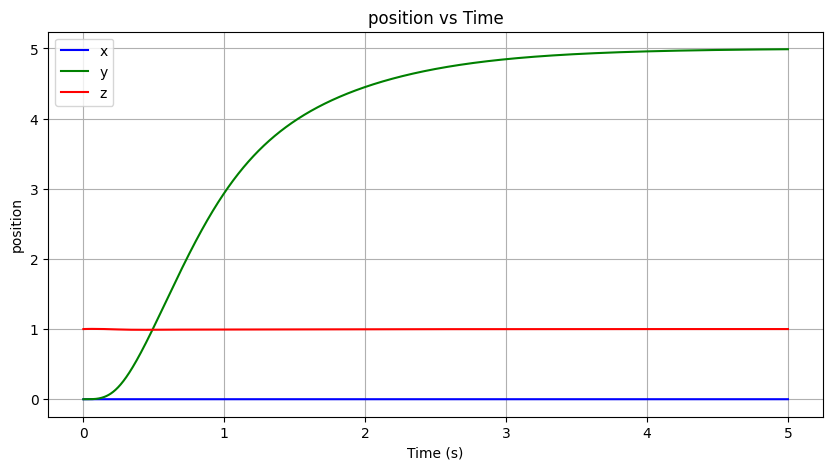

In [9]:
# Generate time array based on fixed step interval
time_log = np.arange(len(x_log)) * dt

# Plot theta and control input vs. time
plt.figure(figsize=(10, 5))
plt.plot(time_log, x_log, label="x", color="blue")
plt.plot(time_log, y_log, label="y", color="green")
plt.plot(time_log, z_log, label="z", color="red")
plt.xlabel("Time (s)")
plt.ylabel("position")
plt.title("position vs Time")
plt.legend()
plt.grid()
plt.show()


The drone was stabilized at the desired position: (0, 5, 1)

Plot of control input

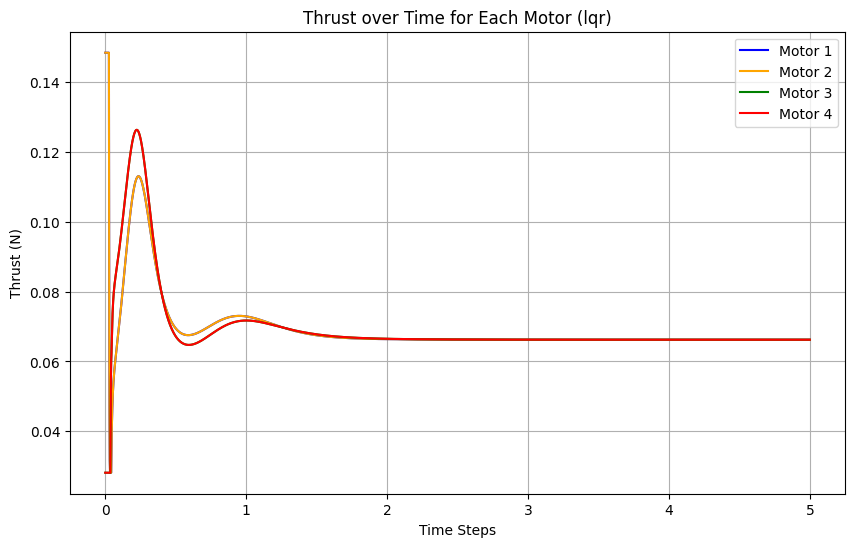

In [10]:
thrust_values = np.array(thrust_log)  # shape: (steps, 4)

time_log = np.arange(thrust_values.shape[0]) * dt

plt.figure(figsize=(10, 6))
plt.plot(time_log, thrust_values[:, 0], label="Motor 1", color="blue")
plt.plot(time_log, thrust_values[:, 1], label="Motor 2", color="orange")
plt.plot(time_log, thrust_values[:, 2], label="Motor 3", color="green")
plt.plot(time_log, thrust_values[:, 3], label="Motor 4", color="red")

plt.xlabel('Time Steps')
plt.ylabel('Thrust (N)')
plt.title('Thrust over Time for Each Motor (lqr)')
plt.legend()
plt.grid()
plt.show()

At the begining, the thrusts reached the maximum thrust of motor.

## 2.2 ILQR

Define desired point.

In [11]:
x_d = np.array([0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0])  # State equilibrium 
u_d = np.ones(4, dtype=np.float32) * 0.25 * MASS * GRAVITY  # Control equilibrium

### 2.2.1 Initializaion of control policy

Using LQR gain to initialize our control policy.

$$
\begin{aligned}
\mu_k(x_k) & = \bar{u}_k + \delta u_k^* \\
           & = \bar{u}_k - gain * \delta x_k \\
           & = \bar{u}_k - gain * (x_k - \bar{x}_k) \\
           & = \underbrace{\bar{u}_k + gain * \bar{x}_k}_{\text{feedforward } u_{k,\text{ff}}} 
            \underbrace{ - gain * x_k}_{\text{feedback}} \\
           & = u_{k,\text{ff}} + gain_{fb} * x_k.
\end{aligned}
$$

In [15]:
input_ff = u_op + gain_lqr.dot(x_op)
gains_fb = - gain_lqr

input_ff = np.tile(input_ff.reshape(4, 1), (1, 2500))
gains_fb = np.tile(gains_fb.reshape(1, nu, nx), (2500, 1, 1))

print('Shape of input_ff:',input_ff.shape)
print('Shape of gains_fb:',gains_fb.shape)

Shape of input_ff: (4, 2500)
Shape of gains_fb: (2500, 4, 12)


### 2.2.2 Define cost function

In [13]:
q_diag = [
    5, 3,
    5, 3, 
    5, 3,   
    0.1, 0.1, 2,      
    1, 1, 1  
]
r_diag = [1, 1, 1, 1]
Q_ilqr = np.diag(q_diag)  # State cost weight
R_ilqr = np.diag(r_diag)  # Input cost weight

### 2.2.3 Recursion

In [16]:
input_stack = 0
iter = 0
max_iteration = 15
duff = 0
norm_threshold = 0.01
cost = []  #

while iter <= max_iteration and (np.linalg.norm(np.squeeze(duff)) > norm_threshold or iter == 0):
    
    input_pre = input_stack

    # Forward / "rollout" of the current policy
    obs, info = envs.reset() #seed=SEED)
    state = obs_to_state(obs) # (12,)

    for step in range(2500):

        # Calculate control input.
        control_input = input_ff[:, step] + gains_fb[step].dot(state) 
        
        # Clip the control input to the specified range
        control_input = np.clip(control_input, 0.028161688, 0.14834145) 
        
        # Convert to np.ndarray
        action = np.array([control_input], dtype=np.float32) # (1, 4)

        # Save rollout data.
        if step == 0:
            # Initialize state and input stack.
            state_stack = state
            input_stack = action
        else:
            # Save state and input.
            state_stack = np.vstack((state_stack, state)) # (N, 12)
            input_stack = np.vstack((input_stack, action)) # (N, 4)

        # Step forward.
        obs, reward, terminated, truncated, _ = envs.step(action)
        state = obs_to_state(obs) # (12,)
        
    envs.close()
    
    # TODO: Compute cost to see if it could converge
    # cost_curr = 0
    # for i in range(state_stack.shape[0]):

    # Initialize backward pass.
    state_k = state_stack[-1].reshape(-1, 1) # (12, 1)
    input_k = u_op.reshape(-1, 1) # (4, 1)

    loss_k = symbolic_model.loss(
                        x=state_k,
                        u=input_k,
                        Xr=x_d,
                        Ur=u_d,
                        Q=Q_ilqr,
                        R=R_ilqr)
    s = loss_k['l'].toarray()
    Sv = loss_k['l_x'].toarray().transpose()
    Sm = loss_k['l_xx'].toarray().transpose()

    # "Backward pass": Calculate the coefficients (s,Sv,Sm) for the value
    # functions at earlier times by proceeding backwards in time
    # (DP-approach)

    for k in reversed(range(2500)):

        # Get current operating point.
        state_k = state_stack[k] #.reshape(-1, 1) # (12,)
        input_k = input_stack[k] #.reshape(-1, 1) # (4,)

        # Linearized dynamics about (x_k, u_k).
        df_k = symbolic_model.df_func(state_k, input_k)
        Ac_k, Bc_k = df_k[0].toarray(), df_k[1].toarray()
        Ad_k, Bd_k = discretize_linear_system(Ac_k, Bc_k, dt)

        # Jacobian and Hessian of the loss w.r.t. state and input.
        loss_k = symbolic_model.loss(x=state_k,
                                    u=input_k,
                                    Xr=x_d,
                                    Ur=u_d,
                                    Q=Q_ilqr,
                                    R=R_ilqr)

        # Quadratic approximation of cost.
        q = loss_k['l'].toarray()  # l
        Qv = loss_k['l_x'].toarray().transpose()  # dl/dx
        Qm = loss_k['l_xx'].toarray().transpose()  # ddl/dxdx
        Rv = loss_k['l_u'].toarray().transpose()  # dl/du
        Rm = loss_k['l_uu'].toarray().transpose()  # ddl/dudu
        Pm = loss_k['l_xu'].toarray().transpose()  # ddl/dudx

        # Control dependent terms of cost function.
        g = Rv + Bd_k.transpose().dot(Sv)
        G = Pm + Bd_k.transpose().dot(Sm.dot(Ad_k))
        H = Rm + Bd_k.transpose().dot(Sm.dot(Bd_k))

        H = (H + H.transpose()) / 2
        # Trick to make sure H is well-conditioned for inversion
        # if not (np.isinf(np.sum(H)) or np.isnan(np.sum(H))):
        #     H = (H + H.transpose()) / 2
        #     H_eval, H_evec = np.linalg.eig(H)
        #     H_eval[H_eval < 0] = 0.0
        #     H_eval += 1e-6 #lamb

        # X = T^-1 * (L * + 1e-6) * T

        #     H_inv = np.dot(H_evec, np.dot(np.diag(1.0 / H_eval), H_evec.T))

        # Update controller gains.
        assert not np.isinf(H).any(), f"H contains Inf values at time step {k}"
        assert not np.isnan(H).any(), f"H is NaN at timestep {k} at {iter}"
        H_inv = np.linalg.pinv(H)
        assert not np.isnan(H_inv).any(), f"H_inv is NaN at timestep {k}"
        assert not np.isinf(H_inv).any(), f"H_inv contains Inf values at time step {k}"

        duff = -H_inv.dot(g)
        K = -H_inv.dot(G)

        # Update control input.
        input_ff_k = input_k + duff[:, 0] - K.dot(state_k)
        input_ff[:, k] = input_ff_k
        gains_fb[k] = K

        # Update s variables for time step k.
        Sm = Qm + Ad_k.transpose().dot(Sm.dot(Ad_k)) + \
            K.transpose().dot(H.dot(K)) + \
            K.transpose().dot(G) + G.transpose().dot(K)
        Sv = Qv + Ad_k.transpose().dot(Sv) + \
            K.transpose().dot(H.dot(duff)) + K.transpose().dot(g) + \
            G.transpose().dot(duff)
        s = q + s + 0.5 * duff.transpose().dot(H.dot(duff)) + \
            duff.transpose().dot(g)
    
    iter += 1

AssertionError: H is NaN at timestep 380 at 12

In [18]:
print(Sm)

[[ 9.02078352e+003  1.56050341e+004  1.95354248e+002  7.12791863e+002
   3.11341179e+000  1.20819010e+001              nan              nan
  -1.17936812e+005              nan              nan              nan]
 [ 1.56050068e+004  3.93290505e+004  7.22327725e+002  2.63669581e+003
   1.07442565e+001  4.17063226e+001              nan              nan
  -3.25317483e+005              nan              nan              nan]
 [ 1.95370694e+002  7.22375873e+002  8.87256847e+003  1.50622572e+004
   1.05779241e-001  1.55667222e-001              nan              nan
  -5.21352881e+003              nan              nan              nan]
 [ 7.12848368e+002  2.63686176e+003  1.50622626e+004  3.73295499e+004
   2.76992992e+000  1.00156403e+001              nan              nan
  -2.11568459e+004              nan              nan              nan]
 [ 3.11385164e+000  1.07450309e+001  1.06163561e-001  2.77106129e+000
   9.71278017e+003  1.82931262e+004              nan              nan
  -1.21539695e+0

In [ ]:
# Step 4: Simulate and plot results
obs, _ = envs.reset()#seed=42)
state = obs_to_state(obs)

x_log_ilqr = [state[0]]
y_log_ilqr = [state[2]]
z_log_ilqr = [state[4]]
thrust_log_ilqr = []

# Simulation loop
for i in range(2500):  # Simulate for 2500 steps
    # envs.render()

    # Compute control action (force) using the iLQR gain
    control_input = input_ff[:, i] + gains_fb[i].dot(state) # gains_fb[:, i].dot(state) + input_ff[i]

    # Clip the control iptput to the specified range
    control_input = np.clip(control_input, 0.028161688, 0.14834145)
    
    # Convert to np.ndarray
    action = np.array([control_input], dtype=np.float32)           

    # Take a step in the environment with the computed action
    obs, reward, terminated, truncated, _ = envs.step(action)
    state = obs_to_state(obs)

    # Log data
    x_log_ilqr.append(state[0])
    y_log_ilqr.append(state[2])
    z_log_ilqr.append(state[4])
    thrust_log_ilqr.append(action.flatten())

    # Check if the episode is terminated
    if terminated or truncated:
        print("Episode ended at step:", i)
        break
    envs.render()
# Close the environment
envs.sim.close()
envs.close()

In [ ]:
# Generate time array based on fixed step interval
time_log = np.arange(len(x_log_ilqr)) * dt

# Plot theta and control input vs. time
plt.figure(figsize=(10, 5))
plt.plot(time_log, x_log_ilqr, label="x(iLQR)", color="blue")
plt.plot(time_log, y_log_ilqr, label="y(iLQR)", color="green")
plt.plot(time_log, z_log_ilqr, label="z(iLQR)", color="red")
# plt.plot(time_log, x_log, label="x(LQR)", color="blue", linestyle="--")
# plt.plot(time_log, y_log, label="y(LQR)", color="green", linestyle="--")
# plt.plot(time_log, z_log, label="z(LQR)", color="red", linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("position")
plt.title("position vs Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
thrust_values_ilqr = np.array(thrust_log_ilqr)  # shape: (steps, 4)

time_log = np.arange(thrust_values.shape[0]) * dt

plt.figure(figsize=(10, 6))
plt.plot(time_log, thrust_values_ilqr[:, 0], label="Motor 1(iLQR)", color="blue")
plt.plot(time_log, thrust_values_ilqr[:, 1], label="Motor 2(iLQR)", color="orange")
plt.plot(time_log, thrust_values_ilqr[:, 2], label="Motor 3(iLQR)", color="green")
plt.plot(time_log, thrust_values_ilqr[:, 3], label="Motor 4(iLQR)", color="red")

# plt.plot(time_log, thrust_values[:, 0], label="Motor 1(LQR)", color="blue", linestyle="--" )
# plt.plot(time_log, thrust_values[:, 1], label="Motor 2(LQR)", color="orange", linestyle="--")
# plt.plot(time_log, thrust_values[:, 2], label="Motor 3(LQR)", color="green", linestyle="--")
# plt.plot(time_log, thrust_values[:, 3], label="Motor 4(LQR)", color="red", linestyle="--")

plt.xlabel('Time Steps')
plt.ylabel('Thrust (N)')
plt.title('Thrust over Time for Each Motor (lqr)')
plt.legend()
plt.grid()
plt.show()